Every year, approximately 7.6 million companion animals end up in U.S. shelters. Many animals are given up as unwanted by their owners, while others are picked up after getting lost or taken out of cruelty situations. Many of these animals find good families to take them home, but just as many are not so lucky. Nearly three million dogs and cats are euthanized in the U.S. every year.

Using a dataset of intake information including breed, color, sex, and age from the Austin Animal Center, I try to predict the final outcome for each animal entering the shelter. It's possible that this dataset can help to understand trends in animal outcomes, and these insights could help shelters focus their energy on specific animals who need a little extra help finding a new home.

Let's begin by importing the appropriate Python libraries and reading in the data set.

In [14]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as mp
%matplotlib inline

df = pd.read_csv('/Users/degrave/DataScience/Site/shelter/train.csv', header=0)

Now that the data is loaded, we can take a quick look at the data column headers to see what we're working with.

In [15]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


Let's also examine the data in another way.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.0+ MB


The data contain information regarding 26,729 animals in ten columns, listing things like animal name, type (cat or dog), outcome type (adoption, transfer, euthanasia, or return to owner), sex, age, breed, and color. We'll go through each of these columns in turn to see what kind of useful information we can extract from them, and do a little feature engineering along the way.

We can start by taking an intial look at the data, just to get a sense for what the various outcome types look like for the cat and dog populations in our sample.

(0, 1)

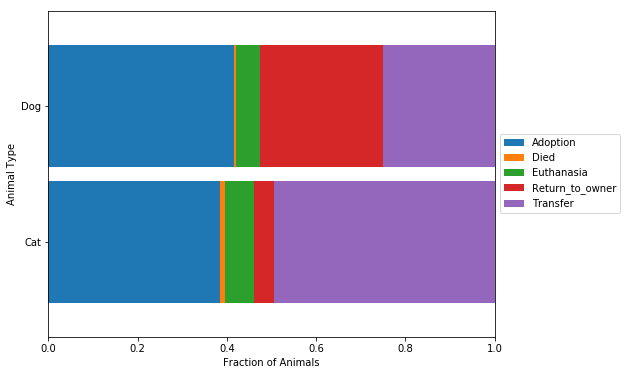

In [17]:
xtab = pd.pivot_table(df, index='AnimalType', columns='OutcomeType', aggfunc='size')
xtab = xtab.div(xtab.sum(axis=1), axis=0)
xtab.plot.barh(stacked=True, width=0.9, figsize=(8,6))

mp.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
mp.xlabel('Fraction of Animals')
mp.ylabel('Animal Type')
mp.xlim(0,1)

It looks like both cats and dogs are much more likely to be adopted, transfered, or returned to their owners than to be euthanized. However, we see that the proportion of these various outcomes differs significantly between animal type. For example, cats are much more likely to be transfered to a different shelter, while dogs are much more likely to be returned to their owners. Perhaps this could partly be attributed to the fact that cats don't wear identification tags as often as dogs?

Okay, let's first take a look at the animal age data. Is it possible that the age of an animal has an impact on what its ultimate fate will be? The data are listed in strings, giving the animal's age in days, months, or years. The age labels appear to be inconsistent. For example, some animal ages have the suffix "year" (i.e. an animal that is 1 year old), while others are labeled in "years" (note the absence of the 's' in year vs. years). Also, several animal ages are missing. There are relatively few of these missing values, though, and we can probably make an educated guess at what they might be close to. Let's first convert the ages to a common set of units (days).

In [18]:
df['AgeuponOutcome'].fillna('100 years', inplace = True)

df['tmp1'] = df['AgeuponOutcome'].apply(lambda x: x.split(' ')[0]).astype(int)
df['tmp2'] = df['AgeuponOutcome'].apply(lambda x: x.split(' ')[1])
df['tmp2'] = df['tmp2'].map(lambda x: x[0].upper() )
df['tmp2'] = df['tmp2'].map({'Y': 365, 'M': 30, 'W': 7, 'D': 1}).astype(int)

df['AgeuponOutcome'] = df['tmp1']*df['tmp2']

df.loc[df['AgeuponOutcome'] == 100*365, 'AgeuponOutcome']  = np.nan

df = df.drop(['tmp1','tmp2'], axis=1)

Now we can look at the distribution of ages.

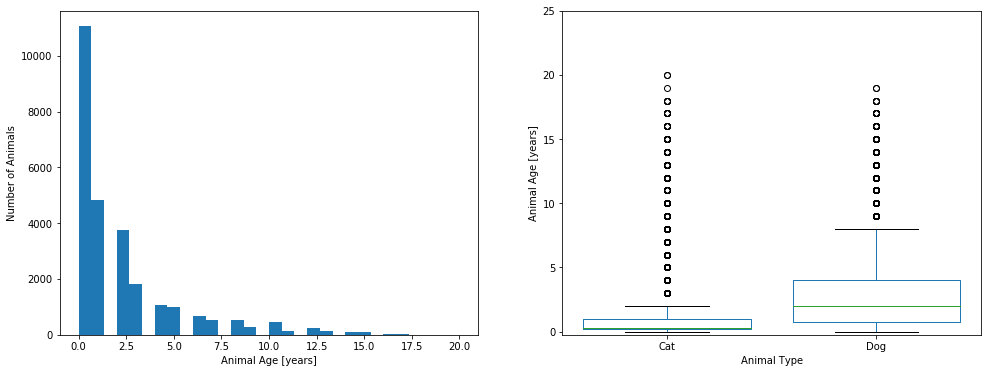

In [35]:
fig, axes = mp.subplots(nrows=1, ncols=2, figsize=(16,6))

df['Age'] = df['AgeuponOutcome']/365

ax = df['Age'].dropna().hist(bins=30, grid=False, ax=axes[0])
ax.set_xlabel('Animal Age [years]')
ax.set_ylabel('Number of Animals')

ax = df.boxplot(by='AnimalType', column='Age', widths=(0.8, 0.8), grid=False, ax=axes[1])
ax.set_xlabel('Animal Type')
ax.set_ylabel('Animal Age [years]')
ax.set_ylim([-0.25,25])
ax.set_title('')
fig.suptitle('')

df.drop('Age', axis=1, inplace=True)

It looks like the vast majority of animals are quite young, with most being less than about one year old. The cat population is much younger than the dog population on average. Let's fill in the missing values with the median value of each animal type.

In [20]:
def fillage(cols):
    Age = cols[0]
    Type = cols[1]

    if pd.isnull(Age):
        if Type == 'Dog':
            return df.loc[df['AnimalType'] == 'Dog', 'AgeuponOutcome'].median()
        elif Type == 'Cat':
            return df.loc[df['AnimalType'] == 'Cat', 'AgeuponOutcome'].median()
    else:
        return Age

df['AgeuponOutcome'] = df[['AgeuponOutcome','AnimalType']].apply(fillage, axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26729 non-null float64
Breed             26729 non-null object
Color             26729 non-null object
dtypes: float64(1), object(9)
memory usage: 2.0+ MB


Let's see if animal age does indeed play a role in the outcome. As an initial guess, we might expect young animals to be adopted more than older ones, and that older animals might also have a higher rate of euthanasia. Because the ages contain a wide range of numerical values, we can break them into a few smaller subgroups to get a clearer picture of what's going on.

In [21]:
df['AgeuponOutcome'].fillna(df['AgeuponOutcome'].median(),inplace = True)

df['AgeGroup'] = np.nan
df.loc[(df['AgeuponOutcome'] >=    0) & (df['AgeuponOutcome'] <=   180), 'AgeGroup'] = '0 - 6mo'
df.loc[(df['AgeuponOutcome'] >   180) & (df['AgeuponOutcome'] <=   365), 'AgeGroup'] = '6mo - 1yr'
df.loc[(df['AgeuponOutcome'] >   365) & (df['AgeuponOutcome'] <= 2*365), 'AgeGroup'] = '1yr - 2yr'
df.loc[(df['AgeuponOutcome'] > 2*365) & (df['AgeuponOutcome'] <= 3*365), 'AgeGroup'] = '2yr - 3yr'
df.loc[(df['AgeuponOutcome'] > 3*365) & (df['AgeuponOutcome'] <= 4*365), 'AgeGroup'] = '3yr - 4yr'
df.loc[(df['AgeuponOutcome'] > 4*365) & (df['AgeuponOutcome'] <= 5*365), 'AgeGroup'] = '4yr - 5yr'
df.loc[(df['AgeuponOutcome'] > 5*365) & (df['AgeuponOutcome'] <= 10*365),'AgeGroup'] = '5yr - 10yr'
df.loc[(df['AgeuponOutcome'] > 10*365), 'AgeGroup']                                   = '> 10yr'

Let's take a look.

(0, 1)

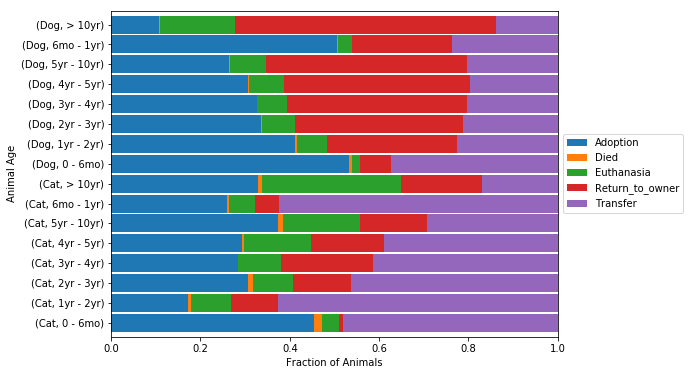

In [22]:
xtab = pd.pivot_table(df, index=['AnimalType','AgeGroup'],columns='OutcomeType', aggfunc='size')
xtab = xtab.div(xtab.sum(axis=1), axis=0)
xtab.plot.barh(stacked=True, width=0.9, figsize=(8,6))

mp.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
mp.xlabel('Fraction of Animals')
mp.ylabel('Animal Age')
mp.xlim(0,1)

It looks like age certainly does play a role, and our initial guess was correct! Younger animals have a significantly higher rate of adoption than do older ones, and the proportion of animals euthanized increases steadily with age. Note, too, that older animals are much more likely to be returned to their owners than are young pets.

The age groups must be encoded if we are to use them in our classifier later. Here, the order of values actually matters, though, so we should not use the Pandas get_dummies function. There aren't many age groups, so we can encode them in order by hand.

In [23]:
df['AgeGroup'] = df['AgeGroup'].map({'0 - 6mo': 0, '6mo - 1yr': 1, '1yr - 2yr': 2, '2yr - 3yr': 3,
                                     '3yr - 4yr': 4, '4yr - 5yr': 5, '5yr - 10yr': 6, '> 10yr': 7})

Next, let's look at animal breeds. Of the 26,729 animals in our sample, there are 1,678 unique breeds listed. We might be able to simplify things greatly while still using this information if we can break the breeds up into smaller subgroups. There are many ways one could go about doing this - for example, separating the dogs into size categories, or into herding or non-herding breeds, etc. For now, however, let's make things a little easier. Many of the breeds are tagged with a "mix" label, meaning that these were clearly not purebred animals when examined at the shelter. Let's make a new column where we separate the animals into two groups depending upon whether or not they are of mixed breed, and see if this makes any difference.

In [24]:
df.loc[~df['Breed'].str.contains('Mix'), 'Breed'] = 'no'
df.loc[df['Breed'].str.contains('Mix'), 'Breed']  = 'yes'

(0, 1)

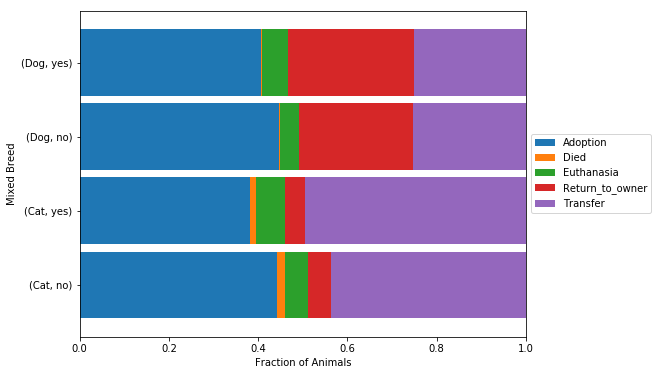

In [26]:
xtab = pd.pivot_table(df, index=['AnimalType','Breed'],columns='OutcomeType', aggfunc='size')
xtab = xtab.div(xtab.sum(axis=1), axis=0)
xtab.plot.barh(stacked=True, width=0.9, figsize=(8,6))

mp.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
mp.xlabel('Fraction of Animals')
mp.ylabel('Mixed Breed')
mp.xlim(0,1)

The figure seems to suggest that purebred animals are somewhat more likely to be adopted or returned to their owners, and less likely to be euthanized than are animals of mixed breed.

The next quantity we can look at is animal color. Is it possible that animals of a particular color or coat-pattern are adopted or returned to their owners more readily than others? There are 366 unique color/coat-pattern combinations listed, some of which are quite complex. They include, for example, names like sable (a shade of brown), brindle (a tiger-striped kind of pattern), and merle (a blotchy pattern often seen in collies and sheepdogs). Again, we can try to simplify this information by breaking it down into smaller groups. To do this, let's create two new columns. In the first, we will keep only the first color listed, ignoring the more complex coat shades and patterns. In the second, we will count the number of unique terms in the color name. For example, "Blue Tabby/White" will be given a value of three for each of the terms blue, tabby, and white. Perhaps animals with more colors listed (indicating a more complex coat color pattern) are more likely to be adopted?

In [27]:
df['tmp'] = df['Color'].apply(lambda x: re.split('[/ ]',x))
df['SimpleColor'] = df['Color'].apply(lambda x: re.split('[/ ]',x)[0])
df['ColorLength'] = df['tmp' ].apply(lambda x: len(set(x)))

df.drop(['Color','tmp'], axis=1, inplace=True)

Taking only the first color listed has now reduced the number of colors from 366 to 29! Let's now look at outcome as a function of these simple colors.

(0, 1)

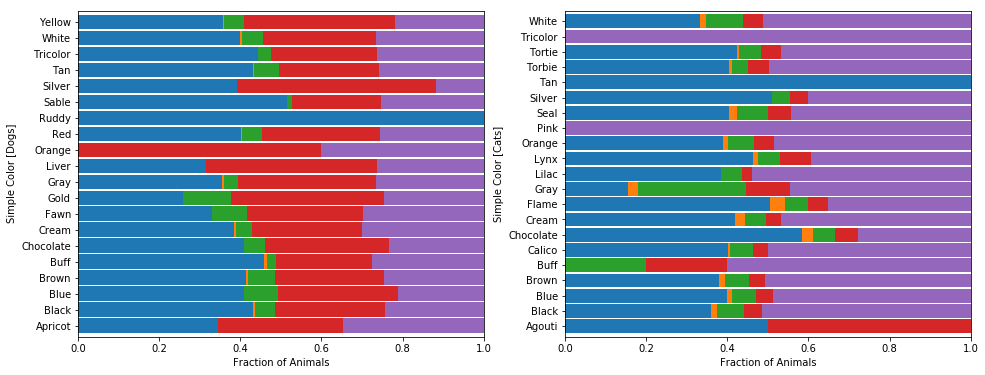

In [36]:
df_dog = df[df['AnimalType'] == 'Dog']
df_cat = df[df['AnimalType'] == 'Cat']

fix, axes = mp.subplots(nrows=1, ncols=2, figsize=(16,6))

xtab = pd.pivot_table(df_dog, index='SimpleColor', columns='OutcomeType', aggfunc='size')
xtab = xtab.div(xtab.sum(axis=1), axis=0)
ax = xtab.plot.barh(stacked=True, layout=(1,2,1), width=0.9, ax=axes[0], legend=None)
ax.set_xlabel('Fraction of Animals')
ax.set_ylabel('Simple Color [Dogs]')
ax.set_xlim(0,1)

xtab = pd.pivot_table(df_cat, index='SimpleColor', columns='OutcomeType', aggfunc='size')
xtab = xtab.div(xtab.sum(axis=1), axis=0)
ax = xtab.plot.barh(stacked=True, layout=(1,2,2), width=0.9, ax=axes[1], legend=None)
ax.set_xlabel('Fraction of Animals')
ax.set_ylabel('Simple Color [Cats]')
ax.set_xlim(0,1)

There appears to be some influence of coat color on outcome, though not as large as I would have expected. For example, dogs with a golden coat color seem to have lower adoption rates than dogs with tan coats, but are also returned to their owners and euthanized more often. Similarly, gray cats have lower adoption rates than most of the other color types, and a larger fraction of them are euthanized. Though not shown here, the number of unique colors listed for each animal does not seem to play as significant a role in determining outcome type.

Our data set also contains a list of date and time stamps recorded upon the final outcome for each animal. These are strings given in a year-month-day-hour format (e.g., 2014-02-12 18:22:00). This information might be useful to us, as certain outcomes might be more likely during different times of the day. For example, maybe animals are returned to their owners and are adopted more often at night when people are not working, while transfers occur more often during working hours.

I first split the time strings up into their individual constituents to recover the numerical values separated by spaces, dashes, and colons. The hour values can then divided into smaller groups denoting the time of day when each outcome occurred.

In [37]:
df['Year']  = df['DateTime'].apply(lambda x: re.split('[-: ]',x)[0]).astype(int)
df['Month'] = df['DateTime'].apply(lambda x: re.split('[-: ]',x)[1]).astype(int)
df['Day']   = df['DateTime'].apply(lambda x: re.split('[-: ]',x)[2]).astype(int)
df['Hour']  = df['DateTime'].apply(lambda x: re.split('[-: ]',x)[3]).astype(int)
df = df.drop('DateTime', axis=1)

df['TimeofDay'] = np.nan
df.loc[(df['Hour'] >=  0) & (df['Hour'] <=  6), 'TimeofDay'] = 'Early Morn.'
df.loc[(df['Hour'] >  6) & (df['Hour'] <= 12), 'TimeofDay']  = 'Morning'
df.loc[(df['Hour'] > 12) & (df['Hour'] <= 18), 'TimeofDay']  = 'Afternoon'
df.loc[(df['Hour'] > 18) & (df['Hour'] <= 24), 'TimeofDay']  = 'Night'

Let's plot the results.

(0, 1)

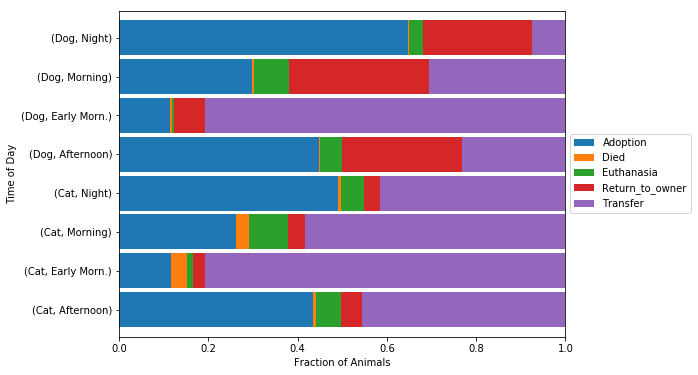

In [42]:
xtab = pd.pivot_table(df, index=['AnimalType','TimeofDay'], columns='OutcomeType', aggfunc='size')
xtab = xtab.div(xtab.sum(axis=1), axis=0)
xtab.plot.barh(stacked=True, width=0.9, figsize=(8,6))

mp.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
mp.xlabel('Fraction of Animals')
mp.ylabel('Time of Day')
mp.xlim(0,1)

It turns out that there is indeed some useful information here! Dogs and cats are both more likely to get adopted (relative to the other outcomes) at night, while a transfers make up a larger fraction during the morning hours. Predictably, relatively few animals are adopted in the early morning hours when people are sleeping, or just beginning their day.

The name of each animal, if available, is also listed in our data set. It seems possible that whether or not an animal has a name could affect what its outcome will be. Perhaps animals with a given name had identification tags when brought to the shelter, and are therefore more likely to be returned to their owners? Perhaps people going to the shelter to adopt are drawn to animals that already have a cute or interesting name? Or maybe people more often adopt animals without a name, preferring to name the animal themselves? Let's take a look! Nameless animals have missing entries here, so let's make a new column listing a 'yes' whenever an animal's name is known, and a 'no' wherever a missing value is present.

In [39]:
df.loc[df['Name'].notnull(), 'Name'] = 'yes'
df.loc[df['Name'].isnull(), 'Name']  = 'no'

Let's look at the results.

(0, 1)

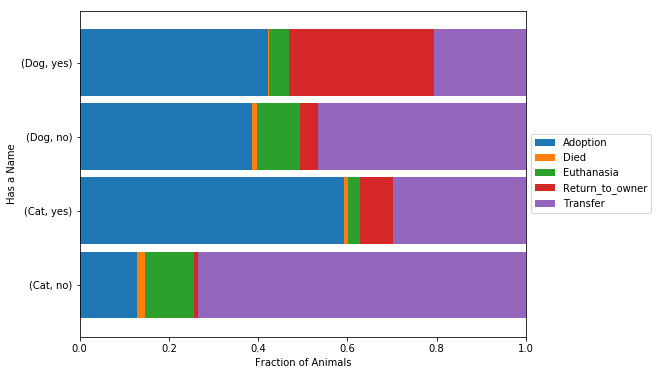

In [41]:
xtab = pd.pivot_table(df, index=['AnimalType','Name'], columns='OutcomeType', aggfunc='size')
xtab = xtab.div(xtab.sum(axis=1), axis=0)
xtab.plot.barh(stacked=True, width=0.9, figsize=(8,6))

mp.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
mp.xlabel('Fraction of Animals')
mp.ylabel('Has a Name')
mp.xlim(0,1)

These results are somewhat surprising to me, as there are very large differences evident between the cat and dog populations. A cat with a name is much, much more likely to be adopted than one without, and is less likely to be euthanized. A cat without a name is more likely to be transfered, and adoption and euthanization rates for these nameless animals are nearly identical. In contrast, it appears that adoption rates for dogs with or without a name are about the same. However, a dog with a name is much more likely to be returned to its owner and is less likely to be euthanized than one without.

The 'SexuponOutcome' column has five categories: neutered or intact male, spayed or intact female, and unknown. We can plot this up.

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

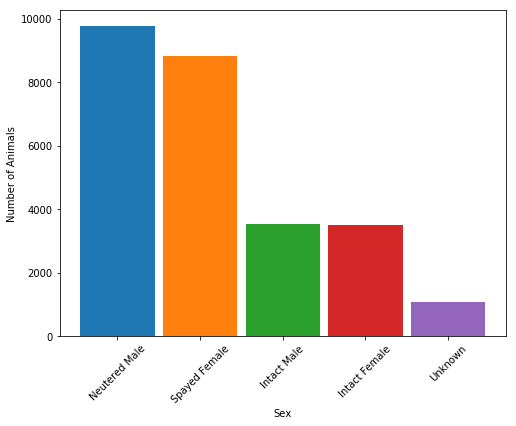

In [48]:
df['SexuponOutcome'].value_counts().plot.bar(width=0.9, rot=0, figsize=(8,6))
mp.xlabel('Sex')
mp.ylabel('Number of Animals')
mp.xticks(rotation=45)

It looks like the majority of animals are spayed or neutered, and there are relatively few animals (about 4% of the total population) of unknown sex. Finally, let's see if the sex of an animal plays a role in outcome.

(0, 1)

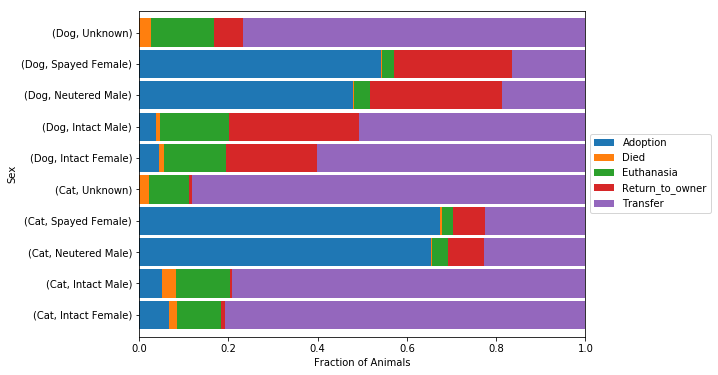

In [49]:
xtab = pd.pivot_table(df, index=['AnimalType','SexuponOutcome'], columns='OutcomeType', aggfunc='size')
xtab = xtab.div(xtab.sum(axis=1), axis=0)
xtab.plot.barh(stacked=True, width=0.9, figsize=(8,6))

mp.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
mp.xlabel('Fraction of Animals')
mp.ylabel('Sex')
mp.xlim(0,1)

It turns out that whether or not an animal is spayed or neutered is one of the most telling features in predicting what its ultimate fate will be. Both cats and dogs, if they're spayed or neutered, are overwhelmingly more likely to be adopted than are intact animals. They're also more likely to be returned to their owners (especially for cats), and less likely to be euthanized.

There is only one missing value in 'SexuponOutcome', and the corresponding name for that animal is Diego. We can assume this is a male, and the most common male is neutered. Let's fill it in with 'Neutered Male'.

In [50]:
df['SexuponOutcome'].fillna('Neutered Male', inplace=True)

Finally, let's drop the 'OutcomeSubtype' column, as this information is not available for the test set.

In [51]:
df.drop('OutcomeSubtype', axis=1, inplace=True)

Lastly, we must encode the categorical values using the get_dummies function, as the the Scikit-Learn classifiers we'll use require all data to be numerical. At the same time, we also scale the non-categorical data to have zero mean and unit standard deviation.

In [52]:
sc = StandardScaler()

df_cat = df.drop(['AnimalID','OutcomeType'], axis=1).select_dtypes(include=['object'])
df_num = df.drop(['AnimalID','OutcomeType'], axis=1).drop(df_cat.columns, axis=1)

df[df_num.columns] = sc.fit_transform(df[df_num.columns])

catdata = pd.get_dummies(df[df_cat.columns], drop_first=True)

df = pd.concat([df.drop(df_cat.columns, axis=1), catdata], axis=1)

The target data must also be numerical, but we encode these values using the LabelEncoder function rather than get_dummies, as the response must be a vector.

In [53]:
enc = LabelEncoder()

df['OutcomeType'] = enc.fit_transform(df['OutcomeType'])

y = df['OutcomeType'].values
X = df.drop(['AnimalID','OutcomeType','AgeGroup'], axis=1)

We'll try three different models here: logistic regression, random forests, and k-nearest neighbors.

In [65]:
models = {'Logistic Regression': LogisticRegression(C=1),
          'Random Forests': RandomForestClassifier(n_estimators=100),
          'k-Nearest Neighbors': KNeighborsClassifier(n_neighbors=7)}

for i in models.keys():
    scores = []
    scores = cross_val_score(models[i], X, y, cv=10)
    mn = np.round(np.mean(scores), 2)
    st = np.round(np.std(scores), 2)
    print(i, (mn, st))

Logistic Regression (0.64, 0.01)
Random Forests (0.66, 0.01)
k-Nearest Neighbors (0.61, 0.01)


Some test above suggests that random forests yield the best results in this classification problem. Having chosen to proceed with random forests, we can use GridSearchCV to tune the n_estimators (number of trees) and max_depth (depth of trees) parameters.

In [64]:
params = {'n_estimators': [200,250,300,350], 'max_depth': [3,5,7]}

grid = GridSearchCV(RandomForestClassifier(), params, cv=5, scoring='accuracy')
grid.fit(X, y)
grid.best_params_

{'max_depth': 7, 'n_estimators': 300}

Parameter tuning suggests that the best values for n_estimators and max_depth are 300 and 7 respectively. We will now use these values in our final classification.

In [67]:
model = RandomForestClassifier(n_estimators=300, max_depth=7)

scores = cross_val_score(model, X, y, cv=10)
print(np.round(np.mean(scores), 2))

0.63


Cross-validation suggests that we correctly predict animal outcome 63% of the time. Not too awful considering there are five possible outcomes, and that random guessing would result in an accuracy of only about 20%. Since we're using Scikit-Learn's RandomForestClassifier, we can look at a list of the ten most important features in the classification proceedure.

In [71]:
n = pd.DataFrame()

n['x'] = feat_labels[indices[:ncomp]]
n['y'] = importances[indices[:ncomp]]

Text(0.5,0,'')

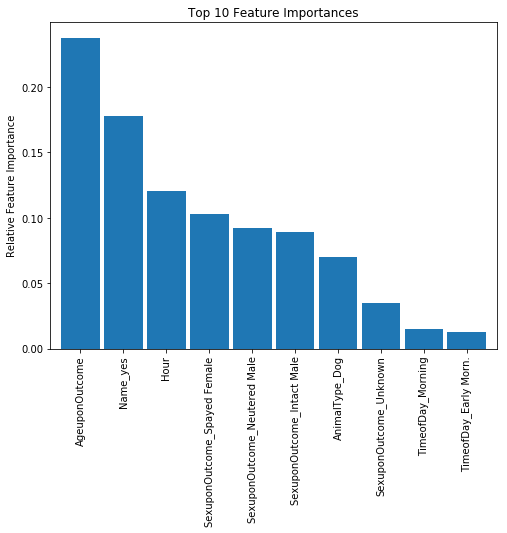

In [72]:
feat_labels = df.drop(['AnimalID','OutcomeType','AgeGroup'], axis=1).columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

ncomp = 10

n.plot.bar(x='x', width=0.9, legend=False, figsize=(8,6))
mp.title('Top 10 Feature Importances')
mp.ylabel('Relative Feature Importance')
mp.xticks(rotation=90)
mp.xlabel('')

Looking at the relative importance of each feature in the classification, we can see that animal age, whether or not an animal has a name, hour of the day, and sex of the animal play the largest roles in determining the outcome. It looks like those time stamps were indeed pretty useful!

Well, that's all for now. Thanks for following along!

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>